# Calculates the El Nino Modoki index (EMI) from the ERSST v5 dataset 

see:  
    
+ [https://climatedataguide.ucar.edu/climate-data/sst-data-noaa-extended-reconstruction-ssts-version-5](https://climatedataguide.ucar.edu/climate-data/sst-data-noaa-extended-reconstruction-ssts-version-5) 
+ [ftp://ftp.ncdc.noaa.gov/pub/data/cmb/ersst/v4/netcdf/](ftp://ftp.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/)
+ http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc (for access via OpenDAP)

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

In [10]:
import pathlib

In [11]:
from datetime import timedelta

In [12]:
import numpy as np
import pandas as pd

In [13]:
from cartopy import crs as ccrs

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [15]:
from scipy.stats import zscore

In [16]:
import xarray as xr

### access the ERSST dataset remotely (ESRL Thredds server: No need for download)

In [17]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"

In [18]:
dset = xr.open_dataset(url, drop_variables=["time_bnds"])

### latitudes in ascending order 

In [19]:
dset = dset.sortby('lat')

### check what is the last month in the data 

In [20]:
dset.time[-1].data

array('2021-10-01T00:00:00.000000000', dtype='datetime64[ns]')

### keep only the data post 1950

In [21]:
dset = dset.sel(time=slice('1950', None))

### loads in memory 

In [22]:
dset = dset.compute()

### function to remove climatological average

In [23]:
def demean(x): 
    return x - x.sel(time=slice('1981','2010')).mean('time')

### calculates the anomalies WRT to climatology

In [27]:
dset_anoms = dset['sst'].groupby('time.month').apply(demean)

### calculates the reginal averages for the 3 "poles" of the EMI 

In [28]:
dom_A = dset_anoms.sel(lat=slice(-10., 10.), lon=slice(165., 220.)).mean(dim='lat').mean(dim='lon')
dom_B = dset_anoms.sel(lat=slice(-15., 5.), lon=slice(250., 290.)).mean(dim='lat').mean(dim='lon')
dom_C = dset_anoms.sel(lat=slice(-10., 20.), lon=slice(125., 145.)).mean(dim='lat').mean(dim='lon')

In [29]:
EMI = dom_A-0.5*dom_B-0.5*dom_C

In [30]:
EMI = EMI.to_dataframe()

In [31]:
EMI.columns = ['EMI']

<AxesSubplot:xlabel='time'>

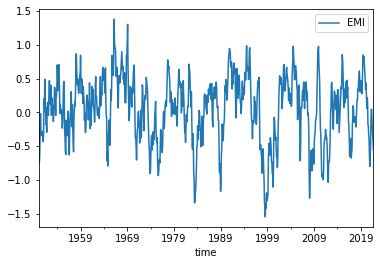

In [32]:
EMI.plot()

### for comparison with the JAMSTEC EMI

In [39]:
# url = 'http://www.jamstec.go.jp/frsgc/research/d1/iod/DATA/emi.monthly.txt'

# jamstect_EMI = pd.read_table(url, header=None, sep=r'[:, \s*]', skiprows=1, engine='python')

# jamstect_EMI.columns = ['year','month','day','time','Box_A','Box_B','Box_C','EMI']

# jamstect_EMI.index = pd.to_datetime(jamstect_EMI[['year','month','day']])

# jamstect_EMI.head()

### shift the index to be the beginning of the month 

In [40]:
# jamstect_EMI.index = jamstect_EMI.index.to_pydatetime() - timedelta(days=15)

In [41]:
# jamstect_EMI.head()

In [42]:
# jamstect_EMI = pd.concat([jamstect_EMI.loc[:,'EMI'], EMI.loc[:,'EMI']], axis=1, join='inner')

### correlation between the JAMSTEC EMI and our newly calculated EMI 

In [43]:
# jamstect_EMI.corr()

In [44]:
# jamstect_EMI.plot()

### calculates the 3 months running means 

In [45]:
EMI

,EMI
time,
1950-01-01,-0.218625
1950-02-01,-0.326593
1950-03-01,-0.738638
1950-04-01,-0.601962
1950-05-01,-0.270306
...,...
2021-05-01,0.048363
2021-06-01,-0.025858
2021-07-01,-0.207300


In [33]:
from scipy.stats import zscore

In [34]:
EMI = EMI.dropna()

In [35]:
EMI = EMI.assign(EMIstd = zscore(EMI))

In [36]:
EMI.loc[:,'EMI_seasonal'] = EMI.loc[:,'EMI'].rolling(window=3).mean()

In [37]:
EMI.loc[:,'EMI_seasonal_std'] = EMI.loc[:,'EMIstd'].rolling(window=3).mean()

In [38]:
EMI.to_csv('./EMI.csv')